GNN Intro  On Molecules with GCN layers .Graph Regression 

on this notebook i have some similar stuff

Transductive : model sees all embeddings at start, then we classify using some train mask(specific nodes)
inductive : we sample the embedding at the start, not use all of it.

it is not needed to use softmax with a linear layer after gcn layers to classify , as from Pytorchs page on Crossentropy loss "criterion combines LogSoftmax and NLLLoss in one single class" , so we can skip it.

In [1]:
import os
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt

C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [6]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [48]:
# import dataset
from torch_geometric.datasets import KarateClub

In [63]:
dataset = KarateClub()
print(dataset)
print('============')
print(dataset.num_classes)
print(dataset.num_features)
print(dataset.num_node_features)
print(f'number of edge features : {dataset.num_edge_features}')
print(f'number of graphs :{len(dataset)}')


KarateClub()
4
34
34
number of edge features : 0
number of graphs :1


this dataset consists of 1 graph , 34 nodes and 4 classes , the edges are featureless

In [50]:
# to grab the graphs you need to do data[0]. if it had more , you access more.

data = data[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


#Each graph in PyTorch Geometric is represented by a single Data object, which holds all the information to describe its graph representation. We can print the data object anytime via print(data) to receive a short summary about its attributes and their shapes:


In [51]:
data.edge_index # contains information w

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [52]:
data.x # each of 34 nodes a 34 length feature vector( 34 featutes)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [53]:
data.y # the target label of each node

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

 There also exists an additional attribute called train_mask, which describes for which nodes we already know their community assigments. In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

In [57]:
edge_index = data.edge_index
print(edge_index.t()) # make it a tensor to display

# first is source node, second is target. we can see duplicates of 0->1 and 1->0 since undirected doesnt matte

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 


This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

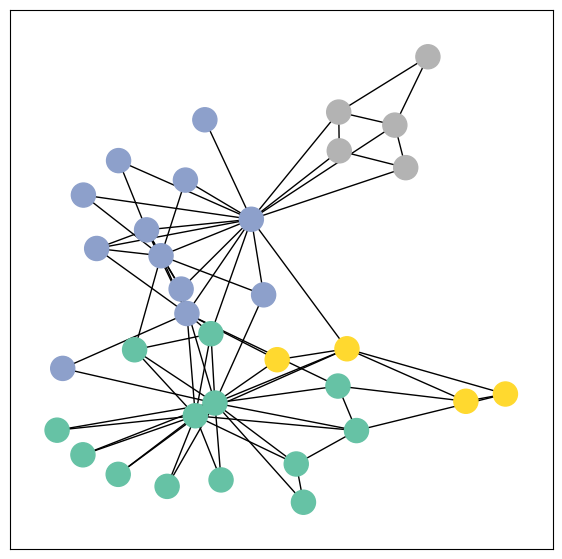

In [58]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True) # convert the data(graph) into a object we can visualize
visualize_graph(G, color=data.y)

## Implementing Graph Neural Networks


For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [2]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [66]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features,4)
        self.conv2 = GCNConv(4,4)
        self.conv3 = GCNConv(4,2)
        self.classifier = Linear(2,dataset.num_classes)
    
    def forward(self, x, edge_index):
        hidden = self.conv1(x,edge_index)
        hidden = hidden.tanh()
        hidden = self.conv2(hidden,edge_index)
        hidden = hidden.tanh()
        hidden = self.conv3(hidden,edge_index)
        hidden = hidden.tanh()
        
        out = self.classifier(hidden)
        
        return out, hidden


model = GCN()
print(model)
        
        

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)




Here, we first initialize all of our building blocks in __init__ and define the computation flow of our network in forward. We first define and stack three graph convolution layers, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away). In addition, the GCNConv layers reduce the node feature dimensionality to 2, i.e., 34→4→4→2. Each GCNConv layer is enhanced by a tanh non-linearity.

After that, we apply a single linear transformation (torch.nn.Linear) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN. We proceed to initialize our final model via GCN(), and printing our model produces a summary of all its used sub-modules.


Embedding shape: [34, 2]


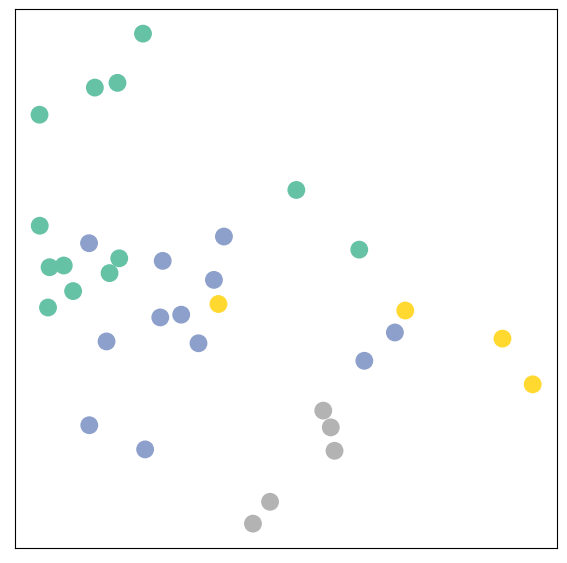

In [67]:
_, hidden = model(data.x, data.edge_index)
print(f'Embedding shape: {list(hidden.shape)}')

visualize_embedding(hidden, color=data.y)


# this is a visualization of embeddings on the 2d space

Remarkably, even before training the weights of our model, the **model produces an embedding of nodes that closely resembles the community-structure of the graph.** Nodes of the same color (community) are already closely clustered together in the embedding space, **lthough the weights of our model are initialized completely at random** and we have not yet performed any training so far! **This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.**


So GNN's have built in "bias" by putting connected nodes closer in embedding space if they are close in the graph.



# Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters **based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):**

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react. Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

In [75]:
import time

In [77]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr =0.01)

In [78]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, hidden = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, hidden

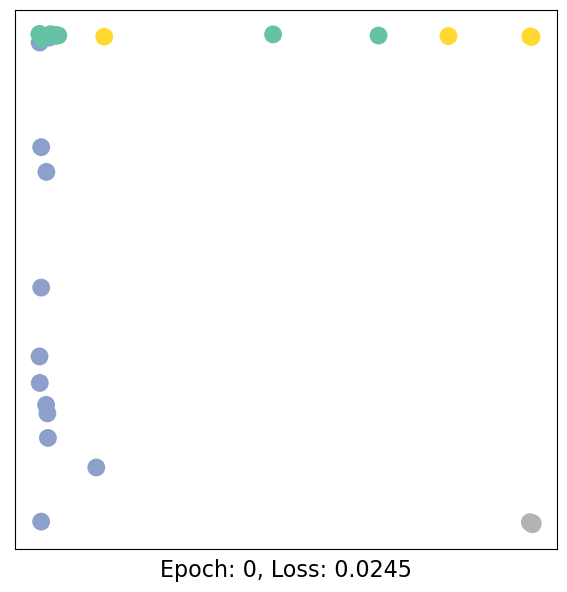

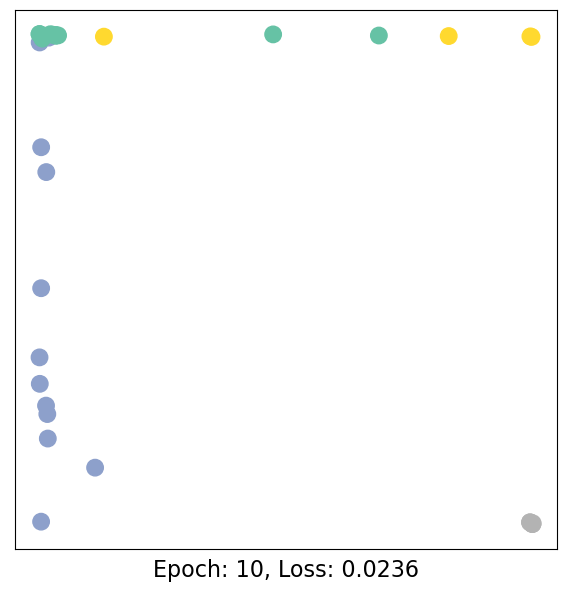

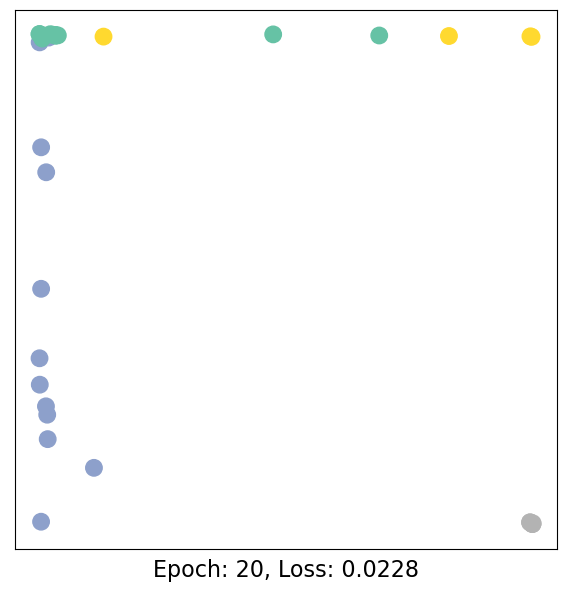

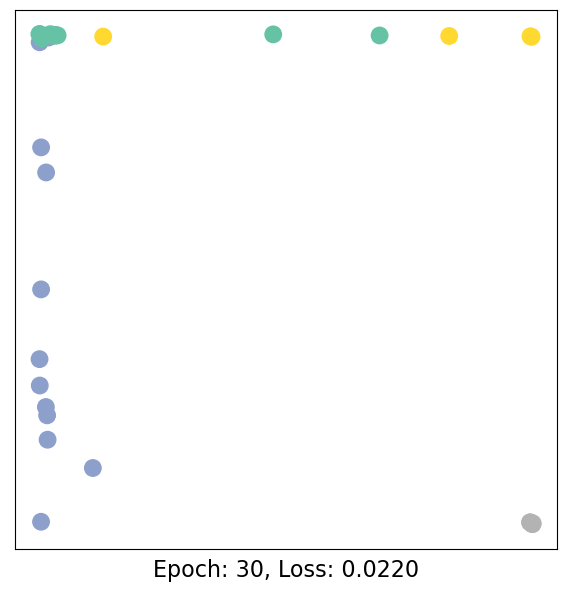

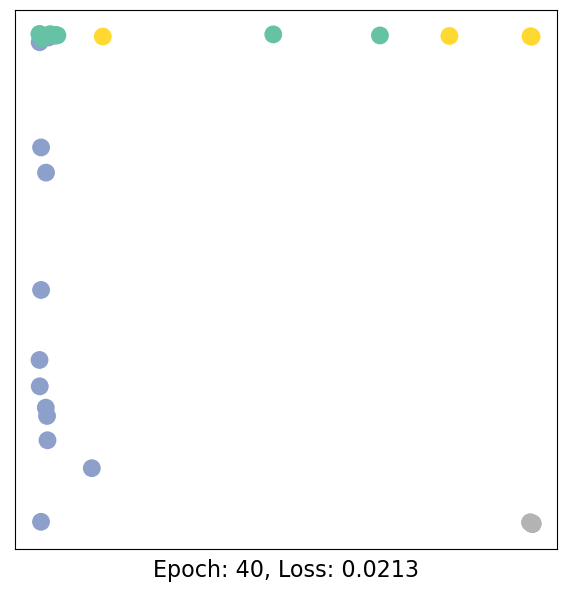

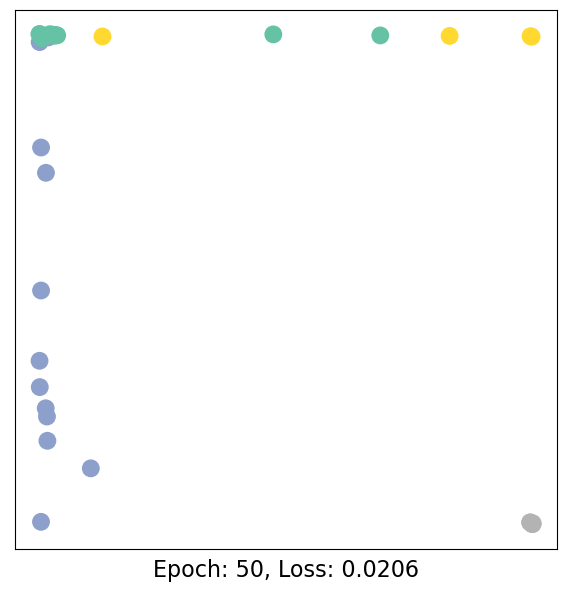

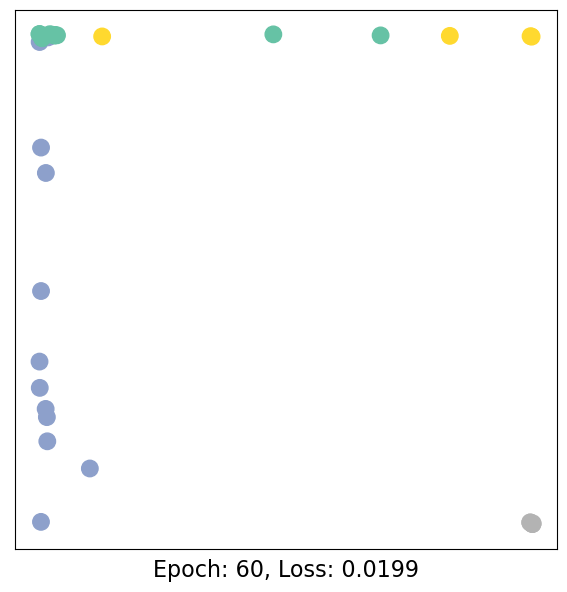

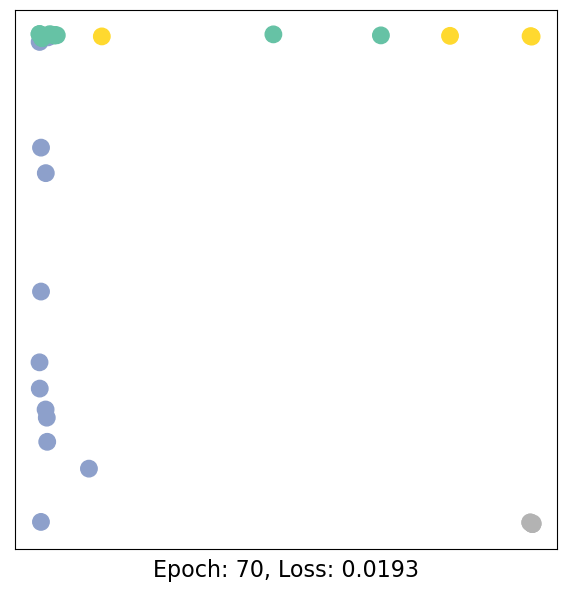

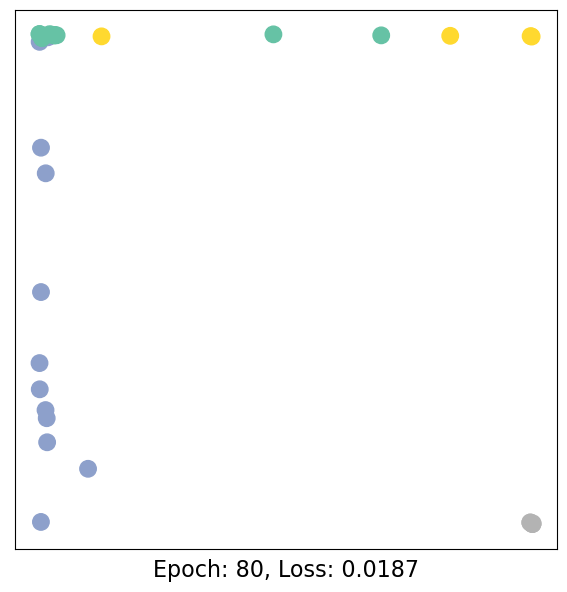

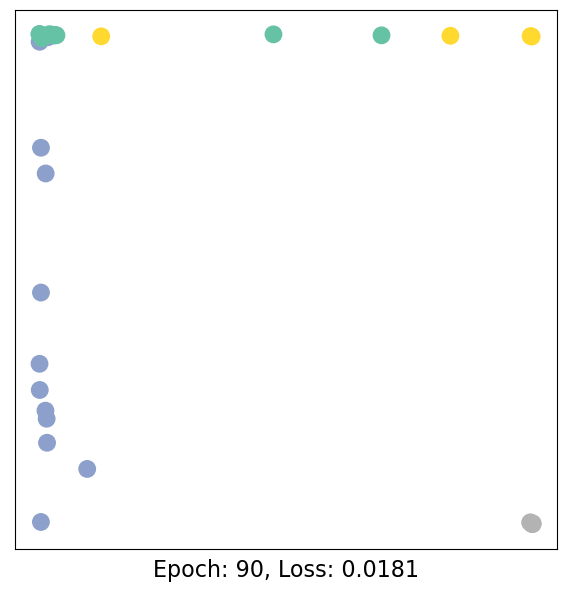

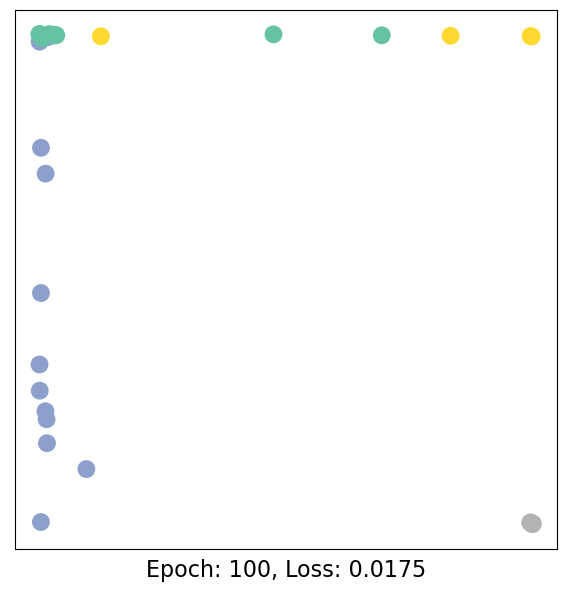

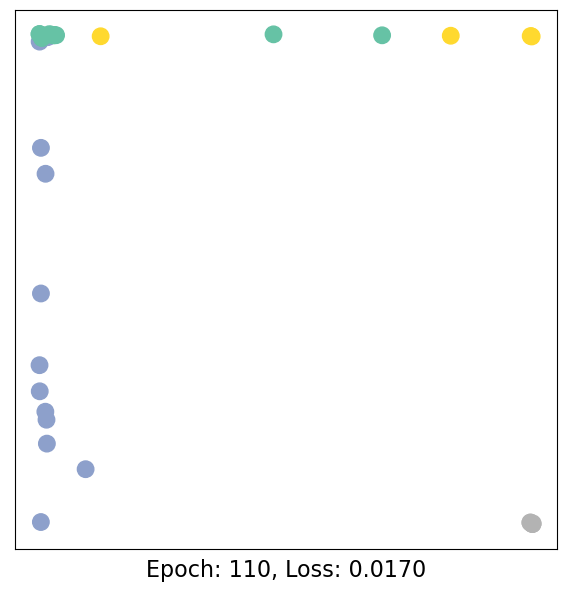

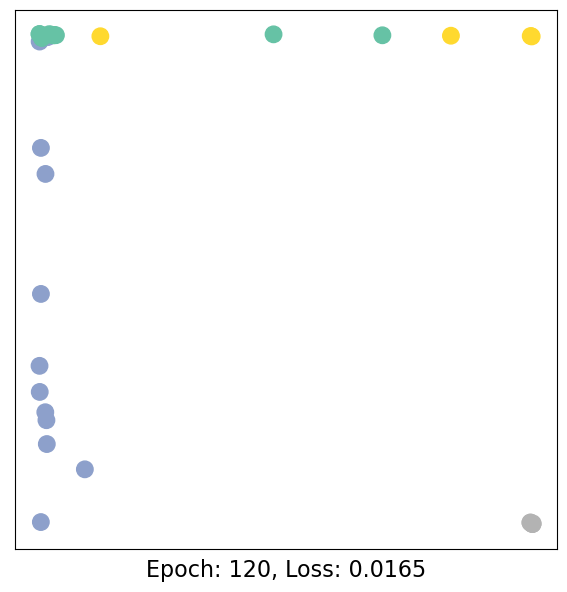

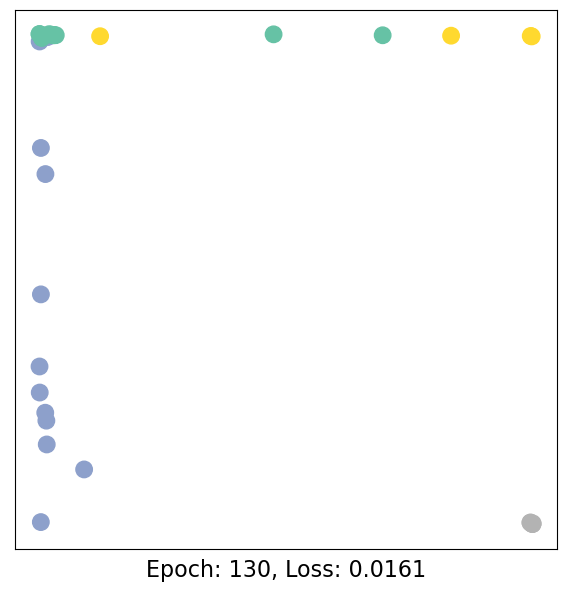

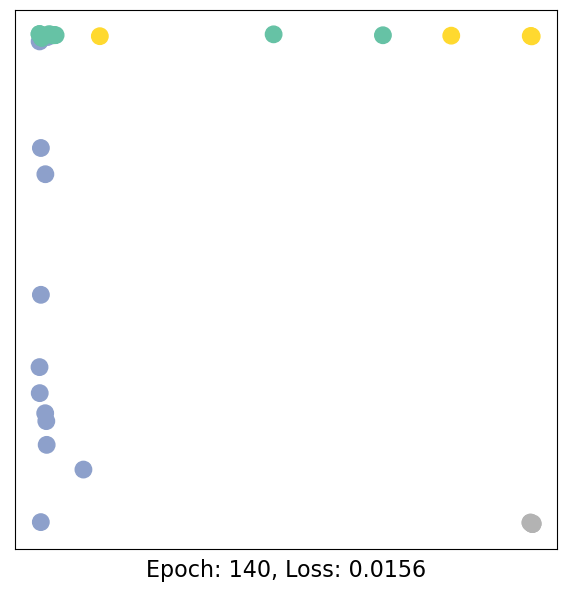

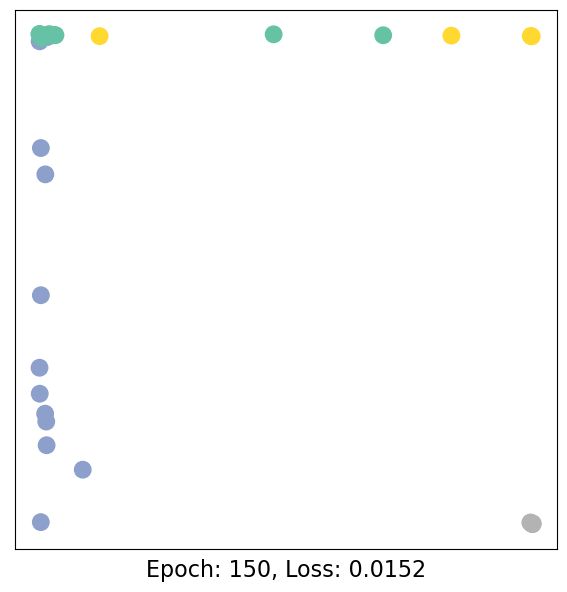

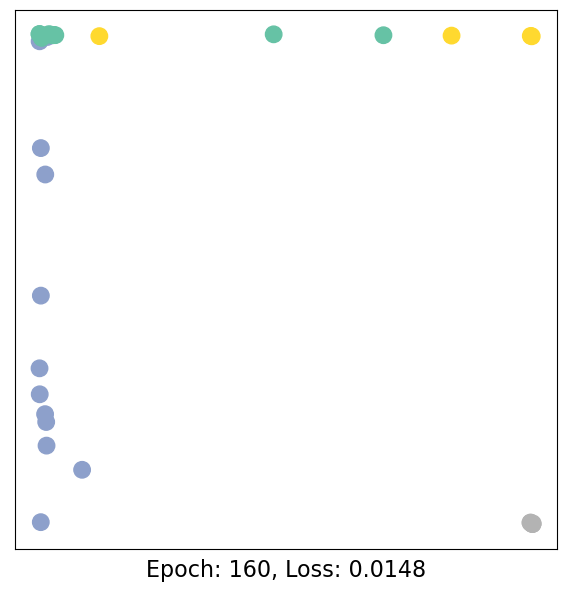

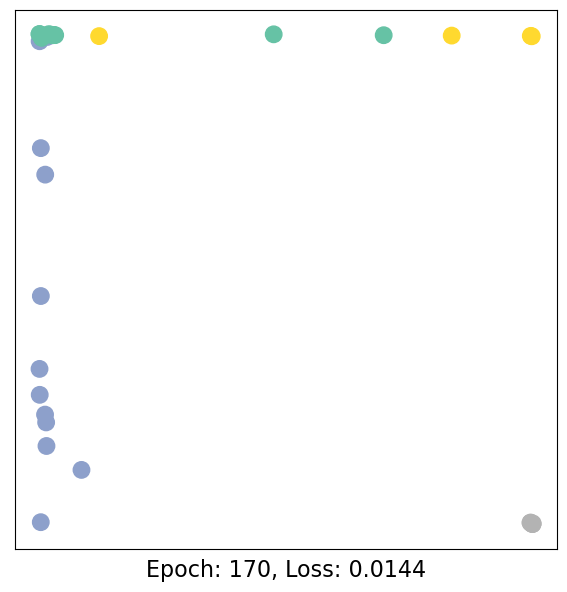

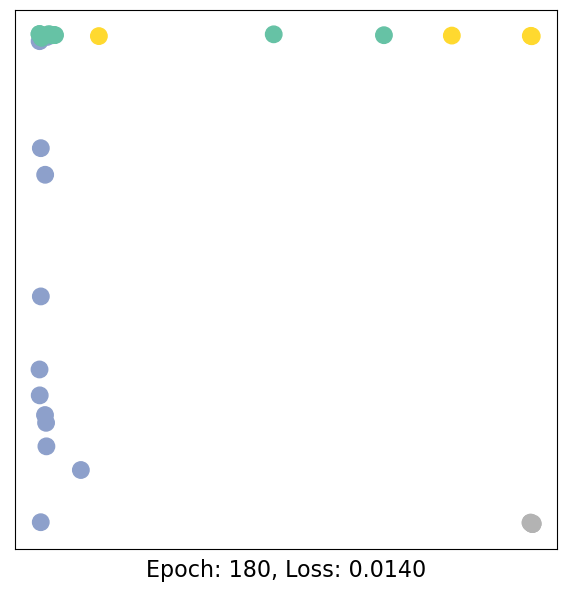

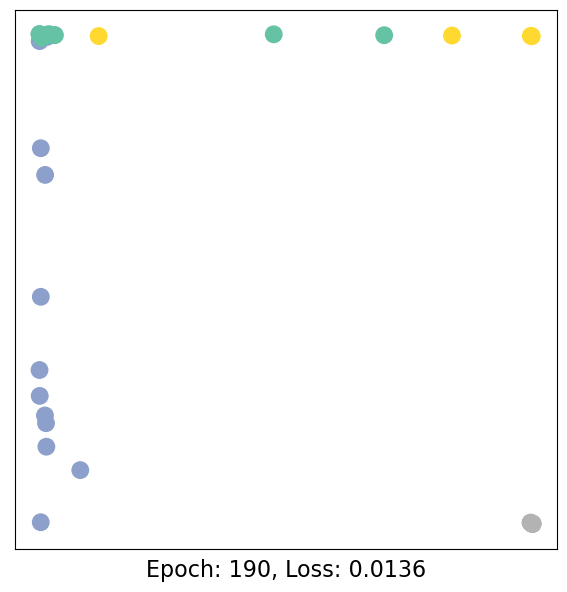

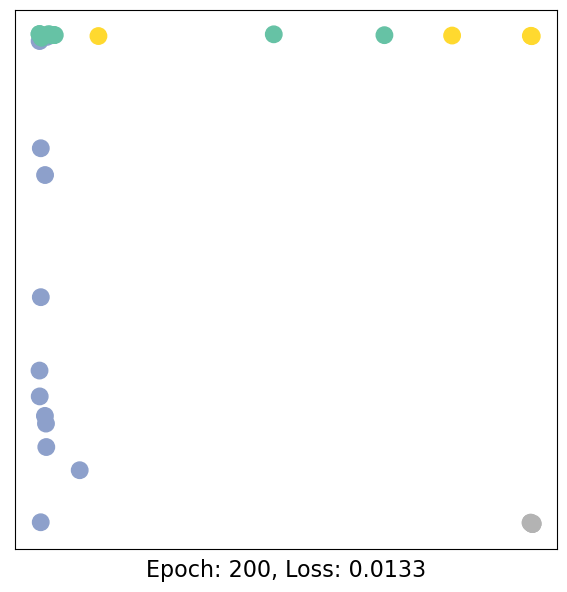

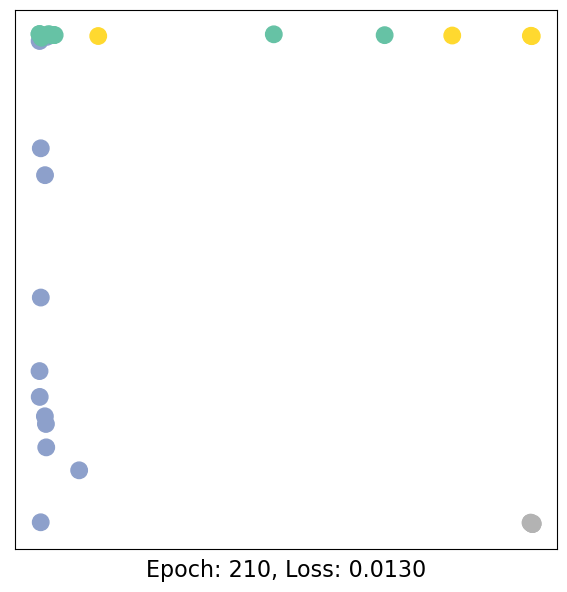

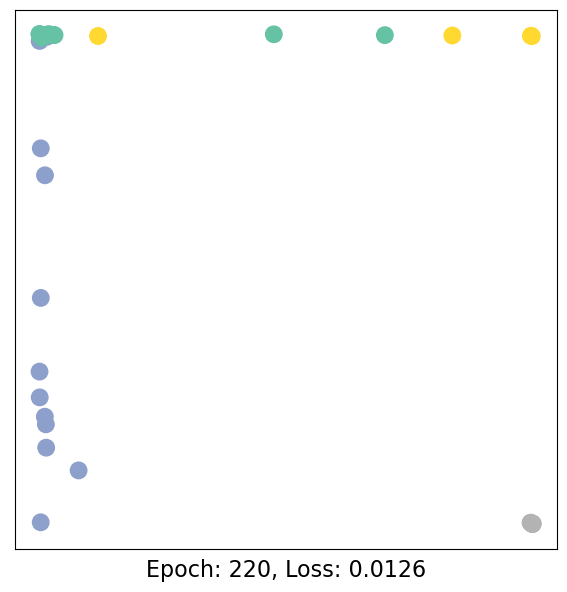

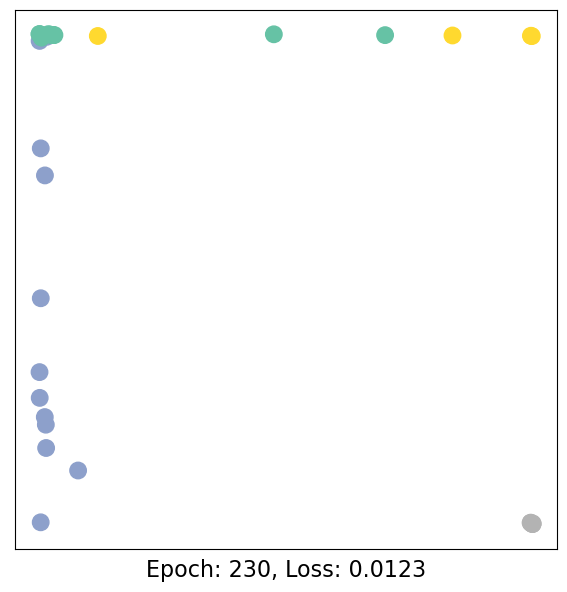

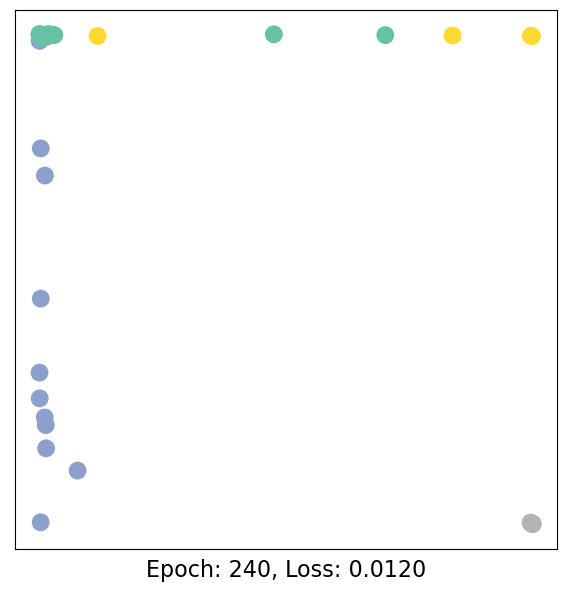

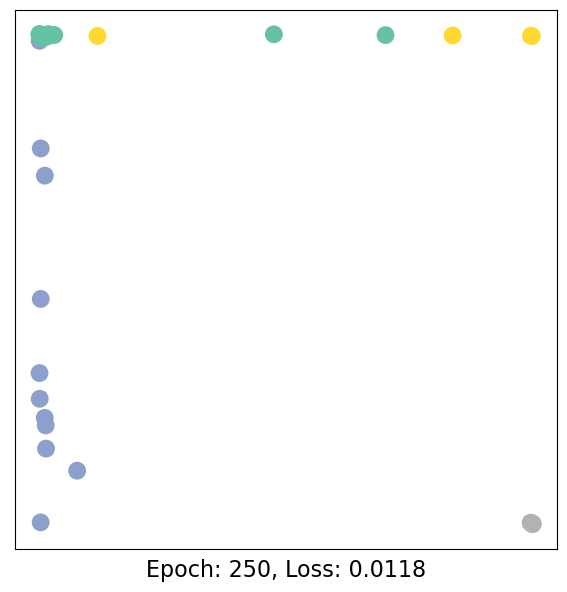

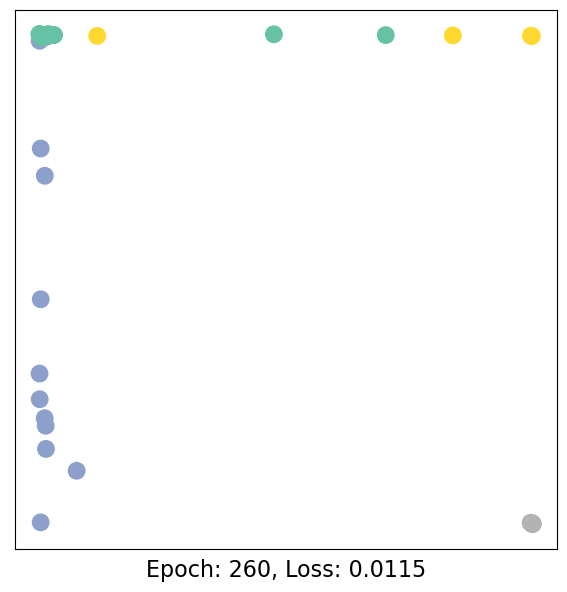

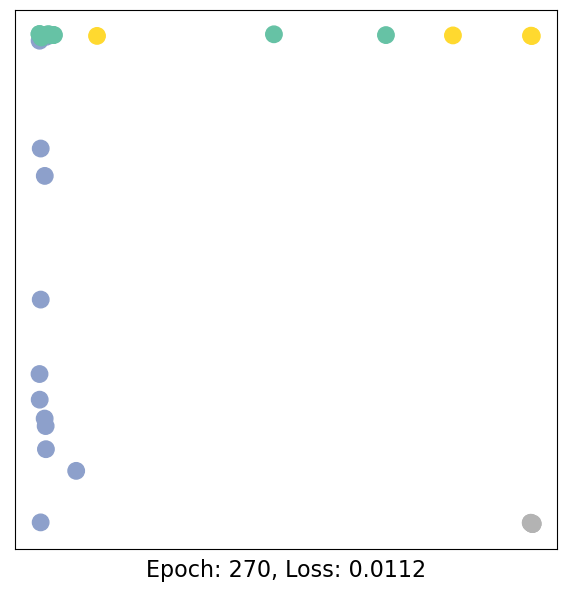

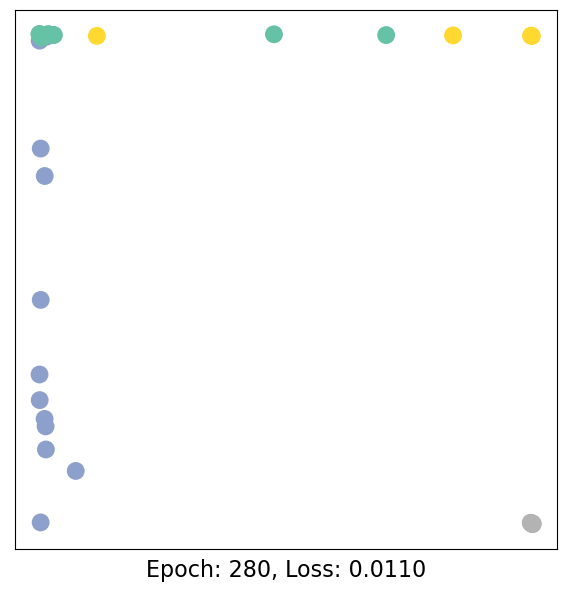

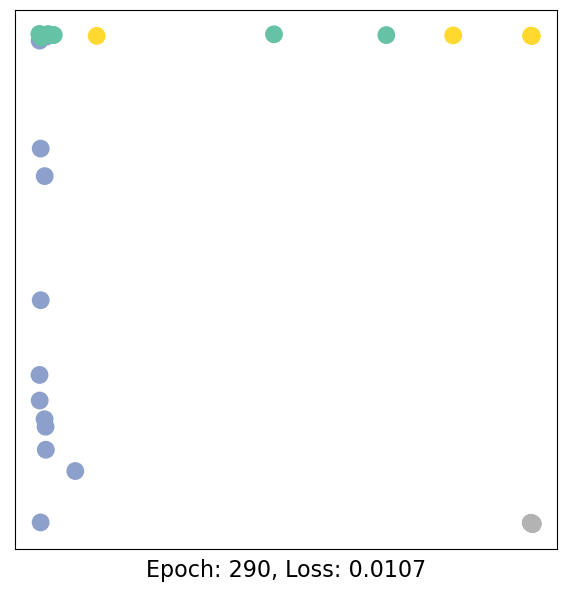

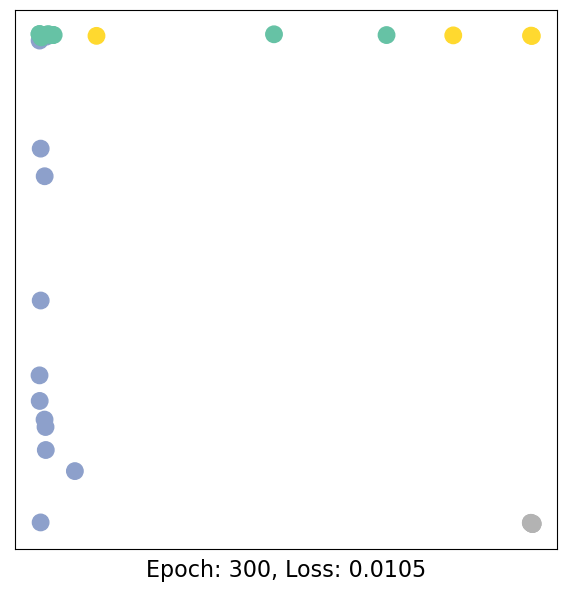

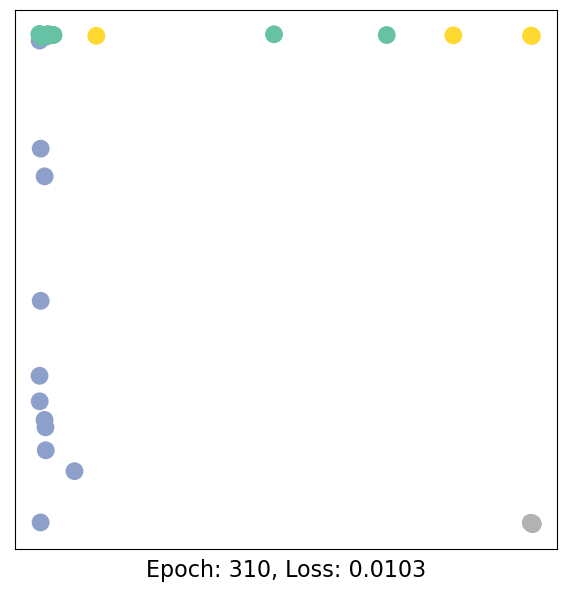

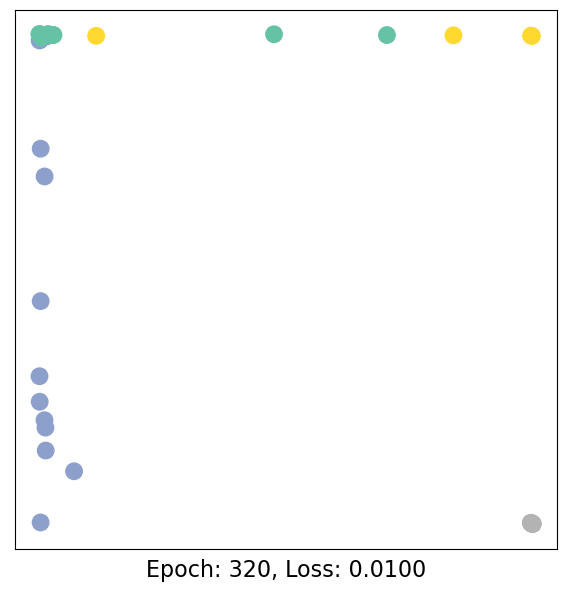

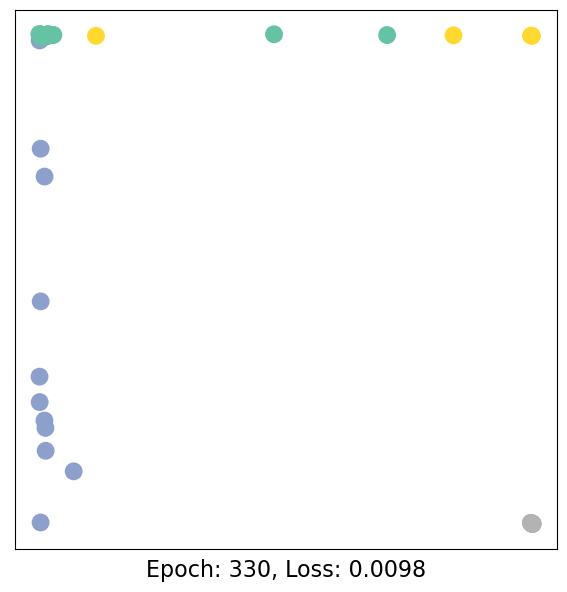

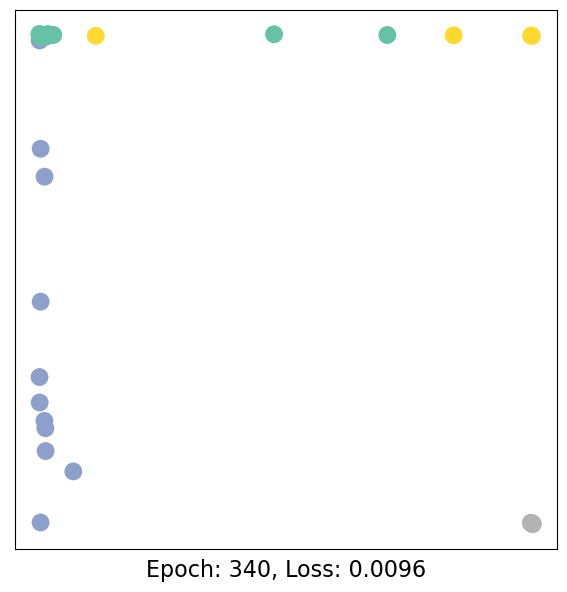

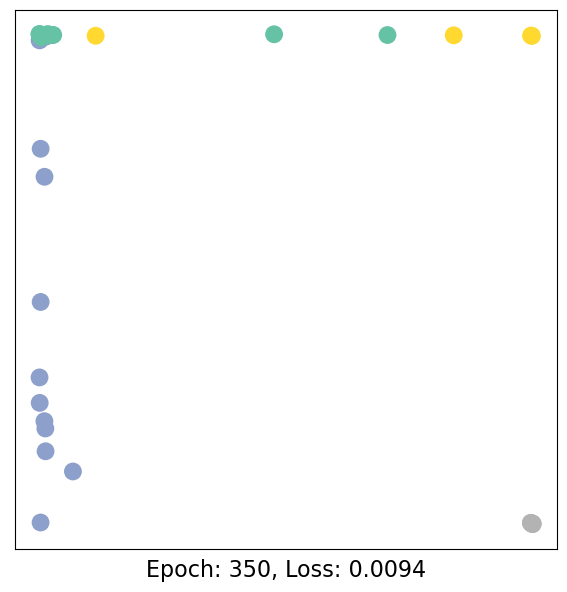

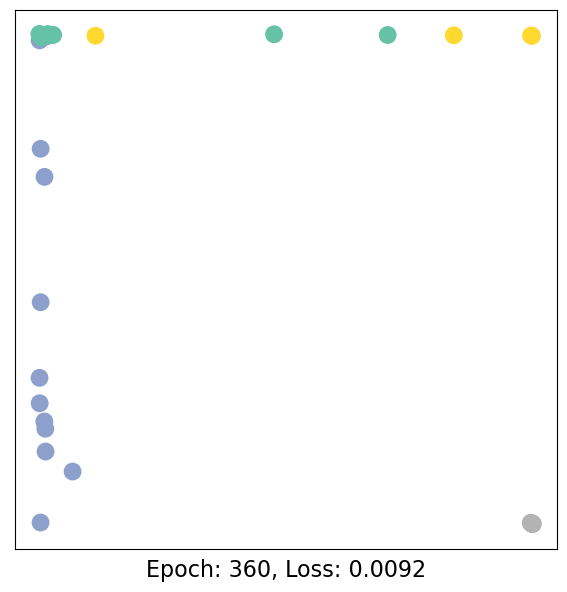

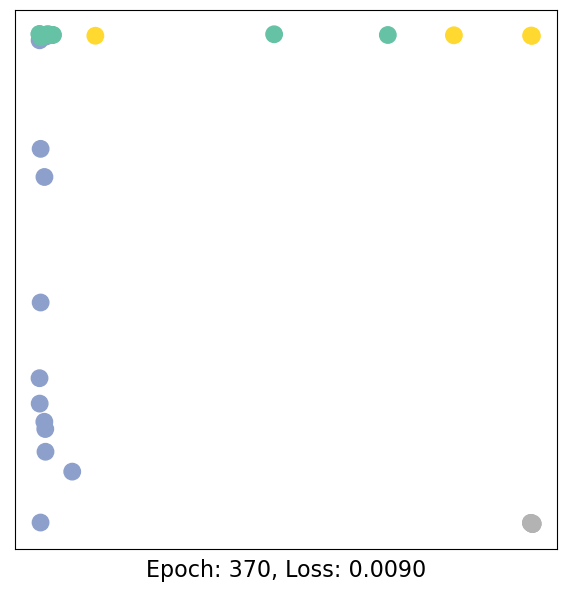

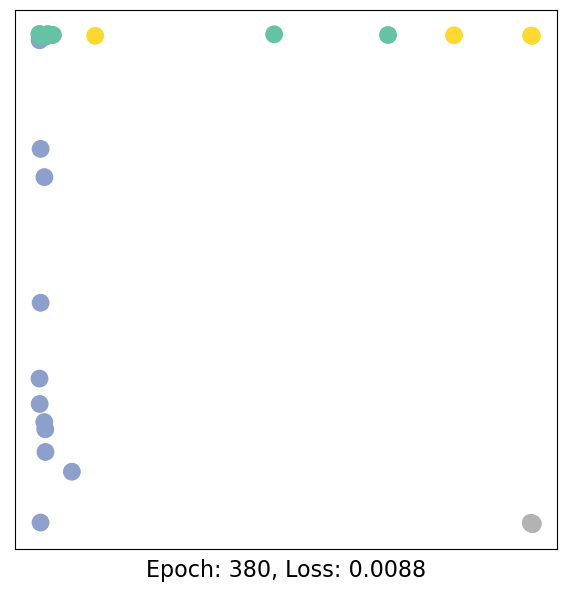

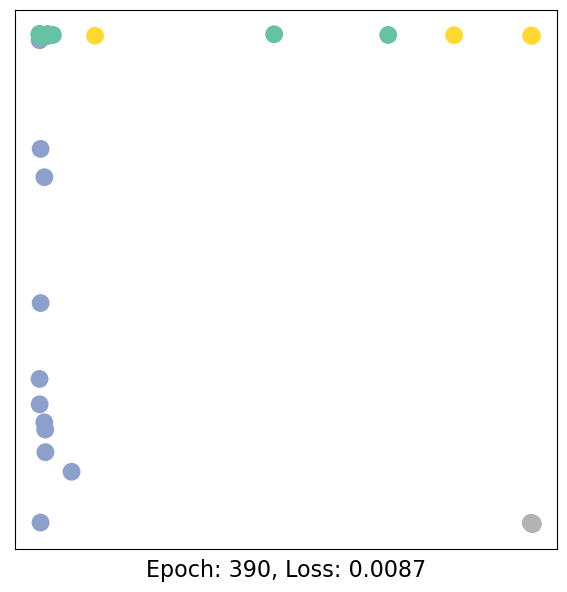

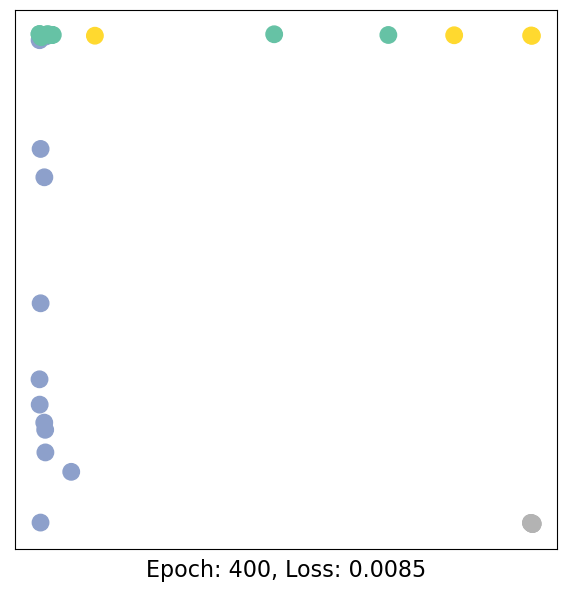

In [80]:

for epoch in range(401):
    loss, hidden = train(data)
    if epoch % 10 == 0:
        visualize_embedding(hidden, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# end of this. now 









# Node classification

 Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (transductive learning).

To demonstrate, we make use of the Cora dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The task is to infer the category of each document (7 in total).

This dataset was first introduced by Yang et al. (2016) as one of the datasets of the Planetoid benchmark suite. We again can make use PyTorch Geometric for an easy access to this dataset via torch_geometric.datasets.Planetoid: (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [4]:
from torch_geometric.datasets import Planetoid # data
from torch_geometric.transforms import NormalizeFeatures  #NormalizeFeatures(attrs: List[str] = ['x'])[source]  Row-normalizes the attributes given in attrs to sum-up to one (functional name: normalize_features).

transform (callable, optional) – A function/transform that takes in an torch_geometric.data.Data object and returns a transformed version. The data object will be transformed before every access. (default: None)


root (string) – Root directory where the dataset should be saved.

name (string) – The name of the dataset ("Cora", "CiteSeer", "PubMed").

In [5]:
dataset = Planetoid(r'C:\Users\NatureChad\DHL WORK\ON GNN', name='Cora',transform = NormalizeFeatures())


In [98]:
len(dataset) # so we have one graph

1

In [6]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [100]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [7]:
data = dataset[0] # get the first and only graph

In [8]:
print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset is similar to Karatenetwork. 1 graph, Cora hold 2708 nodes and 10556 edges, so average node degree 3,9. For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class). This results in a training node label rate of only 5%.

In contrast to KarateClub, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing. Furthermore, we make use of data transformations via transform=NormalizeFeatures(). Transforms can be used to modify your input data before inputting them into a neural network, e.g., for normalization or data augmentation. Here, we row-normalize the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

In [105]:
data.y.unique() # 7 in total labels

tensor([0, 1, 2, 3, 4, 5, 6])

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [11]:
dataset.num_features

1433

In [14]:
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels) # input the BoW encoding, output another encoding/state
        self.lin2 = Linear(hidden_channels, dataset.num_classes) # input the encoding, output the predicted class

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.


We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [15]:


model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9609
Epoch: 002, Loss: 1.9558
Epoch: 003, Loss: 1.9485
Epoch: 004, Loss: 1.9413
Epoch: 005, Loss: 1.9297
Epoch: 006, Loss: 1.9266
Epoch: 007, Loss: 1.9124
Epoch: 008, Loss: 1.9024
Epoch: 009, Loss: 1.8985
Epoch: 010, Loss: 1.8849
Epoch: 011, Loss: 1.8753
Epoch: 012, Loss: 1.8684
Epoch: 013, Loss: 1.8483
Epoch: 014, Loss: 1.8465
Epoch: 015, Loss: 1.8115
Epoch: 016, Loss: 1.8143
Epoch: 017, Loss: 1.7900
Epoch: 018, Loss: 1.7985
Epoch: 019, Loss: 1.7639
Epoch: 020, Loss: 1.7383
Epoch: 021, Loss: 1.7229
Epoch: 022, Loss: 1.7452
Epoch: 023, Loss: 1.7000
Epoch: 024, Loss: 1.6855
Epoch: 025, Loss: 1.6691
Epoch: 026, Loss: 1.6479
Epoch: 027, Loss: 1.6284
Epoch: 028, Loss: 1.5960
Epoch: 029, Loss: 1.5562
Epoch: 030, Loss: 1.5396
Epoch: 031, Loss: 1.5488
Epoch: 032, Loss: 1.5224
Epoch: 033, Loss: 1.4665
Epoch: 034, Loss: 1.4885
Epoch: 035, Loss: 1.4399
Epoch: 036, Loss: 1.4035
Epoch: 037, Loss: 1.4265
Epoch: 038, Loss: 1.3742
Epoch: 039, Loss: 1.3742
Epoch: 040, Loss: 1.3391


After training the model, we can call the `test function` to see how well our model performs on unseen labels. Here, we are interested in the accuracy of the model, i.e., the ratio of correctly classified nodes:

In [110]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


As one can see, our MLP performs rather bad with only about 57.4% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Fwe replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

# explanation of the formula of GCN 

$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}$
$\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}$


- A tilde is the adjacency matrix , added with the identity matrix ( so Adjacency + self loops)
- D tilde is just the degree matrix (sum the row of adjacency tilde)
- the reason you do $^-1/2$ is to normalize the adjacency matrix which results in element wise divison of$1/sqrt(d_i*d_j)$

- W(Θ here) is the projection of feature vectors to a lower dimensional space, e.g. from 1433 to 64 for the Cora dset


- To get graph representation you aggregate those embeddings , scale them , them sum them up with an non linear activ function σ and all good.
say we have 1433 feature vector
imagine H^o. its a matrix of $n_nodesx1433$ . matrix multiplicate it with Θ which is $1433x64$ . get the Nx64 updated embedding.


Regarding embeddings : check node2vec. they use random walks. in a nutshell, they train embeddings s.t. close nodes have similar embeddings like word2vec.

- last, you can view the GCN as a specific case of a GAT. Instead of learning the expressions(attention weights) , you have them hard coded as $1/sqrt(d_i*d_j)$


In [16]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our untrained GCN network. For visualization, we make use of TSNE to embed our 7-dimensional node embeddings onto a 2D plane.

C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


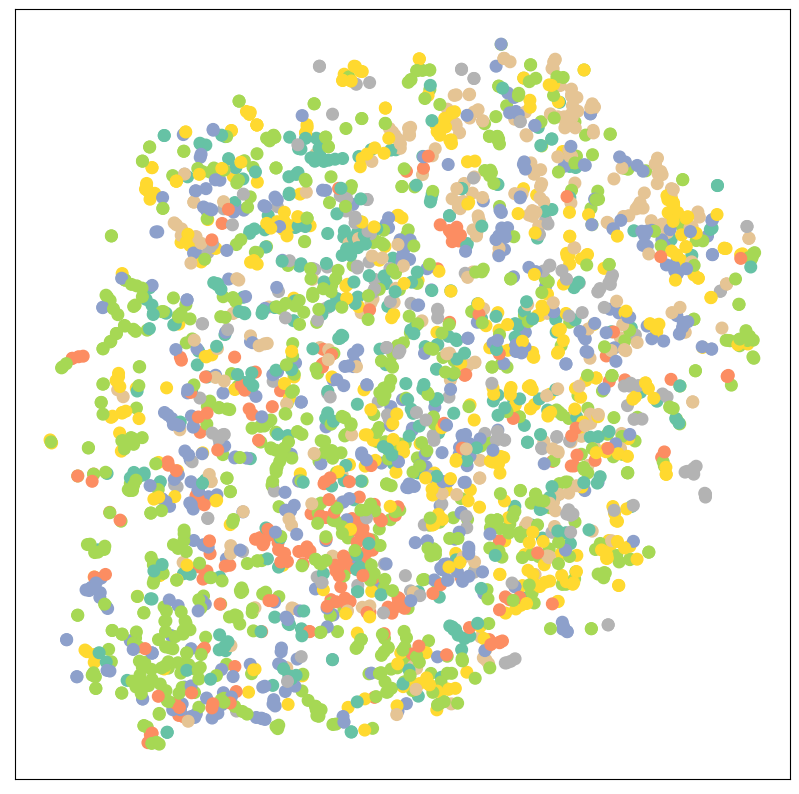

In [17]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model, this looks shit. The training and testing procedure is once again the same, but this time we make use of the node features x and the graph connectivity edge_index as input to our GCN model.

In [18]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


In [19]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


There it is! By simply swapping the linear layers with GNN layers, we can reach 81% of test accuracy! This is in stark contrast to the 57% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our trained model, which now produces a far better clustering of nodes of the same category.


C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


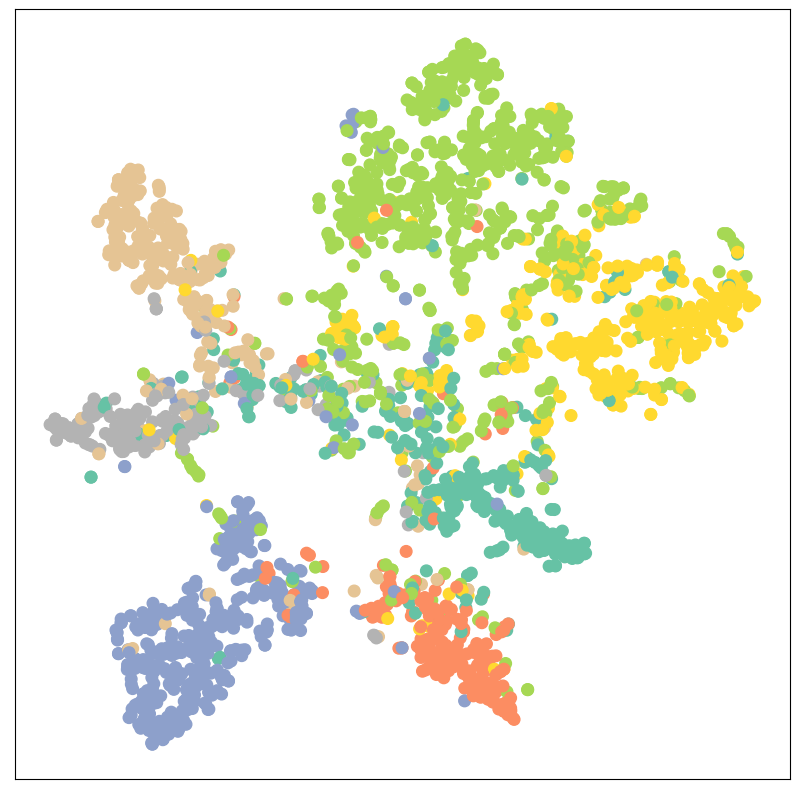

In [20]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

See how much better the embeddings are seperated between the classes. superb , just by changing layers and taking into account the relational information.

what will happen if i change the gcn output layer to linear layer? with a softmax to activate. how can i use validation set?


to do : 


- optional exercises at the end of the colab code
- next colabbook which is similar
- then before you move to the other colab book(graph classif) check the following links :
    - https://mlabonne.github.io/blog/intrognn/
    - https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html
    - and in general formulate the GCN's and GAT's in your head.
- then move on as shown in previous notebook


- also check this stuffs : https://tkipf.github.io/graph-convolutional-networks/ , https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms and general pytorch documentation over time.




- https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=10 ( big project)
- Traffic forecasting (pytorch geom temporal) , fraud detection , reccomender systems etc.. 
- GNN courses i had found 
- look at notes in my note's book or the big notebook for more links etc. or booksmarks on both laptops.
- mention the other libraries 
- start trying to see how and if TGN for logistics can be performed 

Building upon the previous stuff 

Same thing as before but with GAT layer instead of GCN

https://dsgiitr.com/blogs/gat/

# Trying out GAT and some experiments with many many layers 

In [21]:
dataset.num_features

1433

In [23]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [37]:
from torch_geometric.nn import GATConv



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads = heads,dropout=0.6)  # c
        self.conv2 = GATConv(hidden_channels*heads,dataset.num_classes,concat =False ,heads = heads, dropout=0.6)  # concat is to do average over the heads

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 1.9456, Val: 0.0820, Test: 0.0910
Epoch: 002, Loss: 1.9450, Val: 0.0900, Test: 0.1170
Epoch: 003, Loss: 1.9440, Val: 0.2440, Test: 0.2740
Epoch: 004, Loss: 1.9433, Val: 0.2560, Test: 0.2610
Epoch: 005, Loss: 1.9428, Val: 0.2720, Test: 0.2860
Epoch: 006, Loss: 1.9415, Val: 0.3840, Test: 0.3890
Epoch: 007, Loss: 1.9414, Val: 0.4920, Test: 0.4900
Epoch: 008, Loss: 1.9415, Val: 0.6820, Test: 0.6690
Epoch: 009, Loss: 1.9394, Val: 0.6720, Test: 0.7110
Epoch: 010, Loss: 1.9385, Val: 0.5880, Test: 0.6300
Epoch: 011, Loss: 1.9383, Val: 0.6000, Test: 0.6250
Epoch: 012, Loss: 1.9353, Val: 0.6460, Test: 0.6430
Epoch: 013, Loss: 1.9334, Val: 0.6520, Test: 0.6630
Epoch: 014, Loss: 1.9330, Val: 0.6800, Test: 0.6950
Epoch: 015, Loss: 1.9304, Val: 0.7100, Test: 0.7230
Epoch: 016, Loss: 1.9289, Val: 0.7280, Test: 0.7350
Epoch: 017, Loss: 1.9260, Val: 0.7640, Test: 0.7450
Epoch: 018, Loss: 1.9281, Val: 0.7700

Epoch: 159, Loss: 0.7634, Val: 0.8020, Test: 0.8200
Epoch: 160, Loss: 0.7390, Val: 0.8000, Test: 0.8170
Epoch: 161, Loss: 0.7378, Val: 0.7980, Test: 0.8130
Epoch: 162, Loss: 0.7335, Val: 0.7960, Test: 0.8150
Epoch: 163, Loss: 0.7431, Val: 0.7980, Test: 0.8150
Epoch: 164, Loss: 0.7144, Val: 0.7980, Test: 0.8140
Epoch: 165, Loss: 0.7178, Val: 0.7980, Test: 0.8170
Epoch: 166, Loss: 0.7283, Val: 0.8000, Test: 0.8200
Epoch: 167, Loss: 0.7552, Val: 0.8000, Test: 0.8210
Epoch: 168, Loss: 0.7157, Val: 0.7960, Test: 0.8220
Epoch: 169, Loss: 0.7303, Val: 0.7980, Test: 0.8230
Epoch: 170, Loss: 0.7745, Val: 0.7980, Test: 0.8250
Epoch: 171, Loss: 0.6899, Val: 0.8000, Test: 0.8270
Epoch: 172, Loss: 0.7294, Val: 0.8000, Test: 0.8250
Epoch: 173, Loss: 0.6376, Val: 0.8080, Test: 0.8240
Epoch: 174, Loss: 0.7369, Val: 0.8080, Test: 0.8250
Epoch: 175, Loss: 0.7253, Val: 0.8080, Test: 0.8240
Epoch: 176, Loss: 0.7019, Val: 0.8060, Test: 0.8230
Epoch: 177, Loss: 0.7284, Val: 0.7980, Test: 0.8230
Epoch: 178, 

So GAT's > GCN's by 1.5% accuracy on the test. sweeet.

I will increase MP layers to see what happens

In [41]:
from torch_geometric.nn import GCNConv

In [58]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x,edge_index)
        x = x.relu()
        x = self.conv4(x,edge_index)
        x = x.relu()
        x = self.conv5(x,edge_index)
        x = x.relu()
        x = self.conv6(x,edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 16)
  (conv6): GCNConv(16, 7)
)


In [59]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9452
Epoch: 003, Loss: 1.9445
Epoch: 004, Loss: 1.9435
Epoch: 005, Loss: 1.9422
Epoch: 006, Loss: 1.9411
Epoch: 007, Loss: 1.9385
Epoch: 008, Loss: 1.9363
Epoch: 009, Loss: 1.9316
Epoch: 010, Loss: 1.9277
Epoch: 011, Loss: 1.9214
Epoch: 012, Loss: 1.9108
Epoch: 013, Loss: 1.9010
Epoch: 014, Loss: 1.8804
Epoch: 015, Loss: 1.8583
Epoch: 016, Loss: 1.8326
Epoch: 017, Loss: 1.8054
Epoch: 018, Loss: 1.7684
Epoch: 019, Loss: 1.7361
Epoch: 020, Loss: 1.6924
Epoch: 021, Loss: 1.6543
Epoch: 022, Loss: 1.6159
Epoch: 023, Loss: 1.5677
Epoch: 024, Loss: 1.5248
Epoch: 025, Loss: 1.5051
Epoch: 026, Loss: 1.4861
Epoch: 027, Loss: 1.4403
Epoch: 028, Loss: 1.4060
Epoch: 029, Loss: 1.4003
Epoch: 030, Loss: 1.3438
Epoch: 031, Loss: 1.3207
Epoch: 032, Loss: 1.2980
Epoch: 033, Loss: 1.2467
Epoch: 034, Loss: 1.2184
Epoch: 035, Loss: 1.2029
Epoch: 036, Loss: 1.1647
Epoch: 037, Loss: 1.1615
Epoch: 038, Loss: 1.1234
Epoch: 039, Loss: 1.0950
Epoch: 040, Loss: 1.0433


In [60]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5940


C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


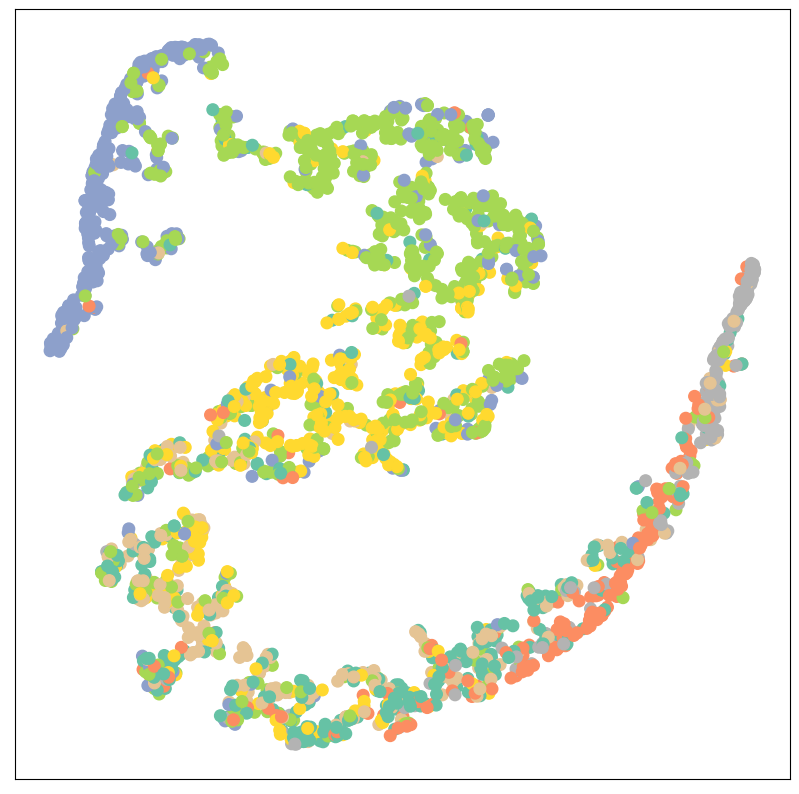

In [61]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

I get the feeling that like the theory suggests, the embeddings get kind of homogenized.

another try with even more layers 

In [71]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels, hidden_channels)
        self.conv7 = GCNConv(hidden_channels, hidden_channels)
        self.conv8 = GCNConv(hidden_channels, hidden_channels)
        self.conv9 = GCNConv(hidden_channels, hidden_channels)
        self.conv10 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x,edge_index)
        x = x.relu()
        x = self.conv4(x,edge_index)
        x = x.relu()
        x = self.conv5(x,edge_index)
        x = x.relu()
        x = self.conv6(x,edge_index)
        x = x.relu()
        x = self.conv7(x,edge_index)
        x = x.relu()
        x = self.conv8(x,edge_index)
        x = x.relu()
        x = self.conv9(x,edge_index)
        x = x.relu()
        x = self.conv10(x,edge_index)
        x = x.relu()
        return x

model2 = GCN(hidden_channels=16)
print(model2)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 16)
  (conv6): GCNConv(16, 16)
  (conv7): GCNConv(16, 16)
  (conv8): GCNConv(16, 16)
  (conv9): GCNConv(16, 16)
  (conv10): GCNConv(16, 7)
)


In [72]:
model2 = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model2.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model2(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model2.eval()
    out = model2(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9460
Epoch: 003, Loss: 1.9459
Epoch: 004, Loss: 1.9458
Epoch: 005, Loss: 1.9457
Epoch: 006, Loss: 1.9456
Epoch: 007, Loss: 1.9455
Epoch: 008, Loss: 1.9454
Epoch: 009, Loss: 1.9453
Epoch: 010, Loss: 1.9452
Epoch: 011, Loss: 1.9451
Epoch: 012, Loss: 1.9450
Epoch: 013, Loss: 1.9449
Epoch: 014, Loss: 1.9448
Epoch: 015, Loss: 1.9447
Epoch: 016, Loss: 1.9446
Epoch: 017, Loss: 1.9445
Epoch: 018, Loss: 1.9443
Epoch: 019, Loss: 1.9442
Epoch: 020, Loss: 1.9440
Epoch: 021, Loss: 1.9439
Epoch: 022, Loss: 1.9437
Epoch: 023, Loss: 1.9436
Epoch: 024, Loss: 1.9434
Epoch: 025, Loss: 1.9433
Epoch: 026, Loss: 1.9432
Epoch: 027, Loss: 1.9430
Epoch: 028, Loss: 1.9429
Epoch: 029, Loss: 1.9427
Epoch: 030, Loss: 1.9426
Epoch: 031, Loss: 1.9425
Epoch: 032, Loss: 1.9424
Epoch: 033, Loss: 1.9422
Epoch: 034, Loss: 1.9421
Epoch: 035, Loss: 1.9420
Epoch: 036, Loss: 1.9419
Epoch: 037, Loss: 1.9418
Epoch: 038, Loss: 1.9417
Epoch: 039, Loss: 1.9416
Epoch: 040, Loss: 1.9415


In [73]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.0940


C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NatureChad\anaconda3\envs\open_uni_dhl_installed_pygeom\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


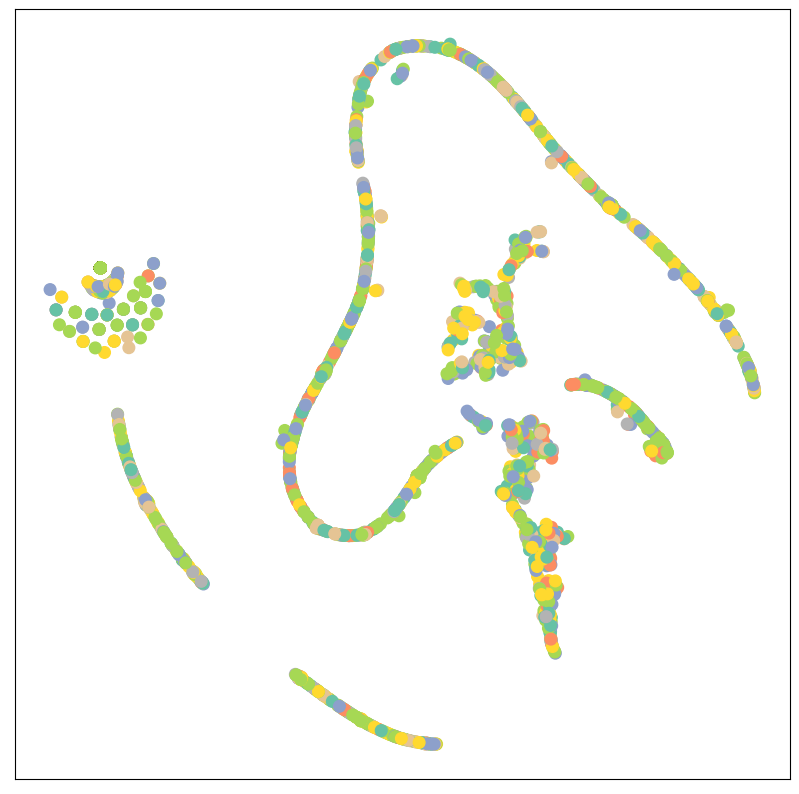

In [74]:
model2.eval()

out = model2(data.x, data.edge_index)
visualize(out, color=data.y)

seems weird, all the embeddings seem stacked together. in any acse bad.

# FINAL : Node classification on Cora dataset using GCN.

https://paperswithcode.com/sota/node-classification-on-cora

current best performance 

In [76]:
dataset

Cora()

In [75]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

There are two special properties we are dealing with in this example:

   - We have one large graph and not many individual graphs (like molecules)
   - We infere on unlabeled nodes in this large graph and hence perform node-level predictions --> We have to use different nodes of the graph depending on what we want to do



In [85]:
data.train_mask.sum()

tensor(140)

In [98]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [102]:
data.x[0] # this is the first node

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [103]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask # this shows which nodes are aimed to be used for test

True


tensor([False, False, False,  ...,  True,  True,  True])

In [104]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [105]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) 
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes) # in order to classify

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [106]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # clear gradients
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # Use the class with highest probability.
    pred = out.argmax(dim=1)  
    # Check against ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8390
Epoch: 200, Loss: 1.7540
Epoch: 300, Loss: 1.5718
Epoch: 400, Loss: 1.4279
Epoch: 500, Loss: 1.3922
Epoch: 600, Loss: 1.3929
Epoch: 700, Loss: 1.4041
Epoch: 800, Loss: 1.4015
Epoch: 900, Loss: 1.3789
Epoch: 1000, Loss: 1.3354


<AxesSubplot:>

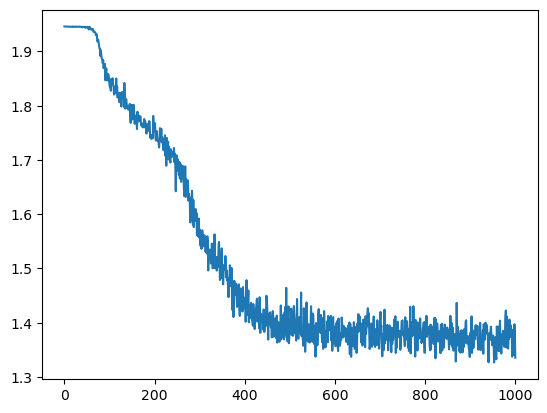

In [108]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [109]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7030
